In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import csv
import sys
#from sklearn.metrics import mean_squared_error
import math
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.engine.topology import Layer
from matplotlib.pyplot import axis
import formatDataSet
import transformations


Using TensorFlow backend.


Running Main FormatDataSet.py ... 

======> Purpose is to Generate Per Subject Models ... 

Reading the Subject Pickle File ... 
  .\Datasets\2016-5-5-13-7\exp_data-2016-5-5-13-7.pickle
.\Datasets\2016-5-5-13-7\DataSet_All.pickle
.\Datasets\2016-5-5-13-7\trialType_All.pickle


C:\Users\kb4000\My Documents\Python\modellingbyrnn\transformations.py:1911: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
def correctForNegativeAngles(trainDataSet, testDataSet):

    A = trainDataSet[:,:,5]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max()) )
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    trainDataSet[:,:,5] = A

    A = testDataSet[:,:,5]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    testDataSet[:,:,5] = A

    A = trainDataSet[:,:,6]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max()) )
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    trainDataSet[:,:,6] = A

    A = testDataSet[:,:,6]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    testDataSet[:,:,6] = A

    A = trainDataSet[:,:,7]
    #print('Before = %2.1f %2.1f %2.1f'% (A.min(), A.max(),A.mean())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f %2.1f'% (A.min(), A.max(), A.mean()))
    trainDataSet[:,:,7] = A

    A = testDataSet[:,:,7]
    #print('Before = %2.1f %2.1f %2.1f'% (A.min(), A.max(),A.mean())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f %2.1f'% (A.min(), A.max(), A.mean()))
    testDataSet[:,:,7] = A
    
    return trainDataSet, testDataSet
    

In [3]:
def createTrainTestDataSets(subjectID):

    integrationLength = 45
    PredictionLength = 35
    blankPeriodDuration = 38
    featureDimension = 17
    # Here we are only creating models during blank
    # For all purpose models this should be changed
    seqLength = integrationLength + blankPeriodDuration

    trainingSize = 108
    testingSize = 27

    pickleFileName = r'.\Datasets\\'+subjectID+'\\DataSet_All-'+ subjectID +'.pickle'

    print('Reading Data Set File ... \n ', pickleFileName)
    eyeToScreenDistance = 0.0725
    ballDiameter = 0.01
    rawDataSet = pd.read_pickle(pickleFileName)
    #print('Raw Data Set Size = ',len(rawDataSet))

    # Resizing for Train DataSet
    allTrialList = sorted(list(rawDataSet.keys()))
    trainTrialList = allTrialList[0:trainingSize]
    #print(trainTrialList)
    #print('Training Len = ', len(trainTrialList))
    trainDataSet = np.zeros((trainingSize, seqLength, featureDimension))
    trainTrialInfo = np.chararray(trainingSize,itemsize = 14)
    cnt = 0
    for trialNumber in trainTrialList:
        #print('Trial Number =', trialNumber)
        currentTrial = rawDataSet[trialNumber]
        tempVar = currentTrial[0:seqLength, :]
        trainDataSet[cnt, :, :] = tempVar
        trainTrialInfo[cnt] = trialNumber
        cnt = cnt + 1

    #print('cnt = ', cnt)
    #print (rawDataSet[trainTrialList[0]].shape)
    print('Train: ', trainDataSet.shape)
    #print(trainTrialInfo.shape)
    #print(trainDataSet[0:5])
    #print(trainTrialInfo[0:5])

    # Resizing for Test DataSet
    testTrialList = allTrialList[trainingSize:]
    #print(testTrialList)
    #print('Testing Len = ', len(testTrialList))
    testDataSet = np.zeros((testingSize, seqLength, featureDimension))
    testTrialInfo = np.chararray(testingSize,itemsize = 14)
    cnt = 0
    for trialNumber in testTrialList:
        #print('Trial Number =', trialNumber)
        currentTrial = rawDataSet[trialNumber]
        tempVar = currentTrial[0:seqLength, :]
        testDataSet[cnt, :, :] = tempVar
        testTrialInfo[cnt] = trialNumber
        cnt = cnt + 1

    #print('cnt = ', cnt)
    #print (rawDataSet[trainTrialList[0]].shape)
    print('Test: ', testDataSet.shape)
    #print(testTrialInfo.shape)
    #print(testDataSet[0:5])
    #print(testTrialInfo[0:5])

    return (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo)

In [4]:
def normalizeDataSet(dataSet):
    size = dataSet.shape
    #print(dataSet.shape)
    rdata = np.reshape(dataSet,(size[0]*size[1],size[2]))
    #print(rdata.shape)

    oldMean = np.mean(rdata, axis=0)
    oldStd = np.std(rdata, axis=0)
    #print('\nmean Before = ', oldMean)
    #print('\nstd Before= ', oldStd)
    # feat_mean = np.array([ -0.56496255,   1.47545376,   0.47065537, -10.3846558,   15.32644376, 38.24852388, -60.86447759,  62.19752817,  52.12331736,   0.70106737])
    # feat_std =  np.array([ 0.25888438,    0.32694775,    0.29356005,    9.35998388,   10.04664913, 60.24531354,   40.3744057,    40.61692218,  135.34311661,    0.45779025])

    normalDataSet = np.zeros(rdata.shape)
    for i in range(len(oldMean)):
        tempVar = rdata[:,i] - oldMean[i]
        normalDataSet[:,i] = np.divide(tempVar,oldStd[i])

    newMean = np.mean(normalDataSet, axis=0)
    newStd = np.std(normalDataSet, axis=0)

    normalDataSet = normalDataSet.reshape(size)
    #print('Final Size = ', normalDataSet.shape)

    #print('\nmean After = ', newMean)
    print('\nstd After= ', newStd)

    '''
    plt.figure(figsize=(12, 10), dpi=200)
    #plt.errorbar(range(len(oldMean)), oldMean, yerr = oldStd, fmt = 'ob', label = 'Before')
    plt.errorbar(range(len(newMean)), newMean, yerr = newStd, fmt = 'or', label = 'After')

    plt.grid(True)
    plt.legend()
    plt.title("Data Normalization Result")
    plt.xlabel('Feature')
    plt.ylabel('Mean')
    #plt.savefig(str(Q)+'SampleTrial'+str(trialNumber)+'.png', dpi=600)
    plt.show()
    '''

    return normalDataSet


In [5]:
def UnnormalizeDataSet(dataSet, dataSet2):
    size = dataSet.shape
    #print(dataSet.shape)
    rdata = np.reshape(dataSet,(size[0]*size[1],size[2]))
    size2 = dataSet2.shape
    rdata2 = np.reshape(dataSet2,(size2[0]*size2[1],size2[2]))
    #print(rdata.shape)

    oldMean = np.mean(rdata, axis=0)
    oldStd = np.std(rdata, axis=0)
    print('\nmean Before = ', oldMean)
    print('\nstd Before= ', oldStd)
    # feat_mean = np.array([ -0.56496255,   1.47545376,   0.47065537, -10.3846558,   15.32644376, 38.24852388, -60.86447759,  62.19752817,  52.12331736,   0.70106737])
    # feat_std =  np.array([ 0.25888438,    0.32694775,    0.29356005,    9.35998388,   10.04664913, 60.24531354,   40.3744057,    40.61692218,  135.34311661,    0.45779025])

    unNormalDataSet = np.zeros(rdata2.shape)
    for i in range(size2[2]):
        tempVar = np.multiply(rdata2[:,i],oldStd[i])
        unNormalDataSet[:,i] =  tempVar + oldMean[i]

    newMean = np.mean(unNormalDataSet, axis=0)
    newStd = np.std(unNormalDataSet, axis=0)

    unNormalDataSet = unNormalDataSet.reshape(size2)
    #print('Final Size = ', normalDataSet.shape)

    print('\nmean After = ', newMean)
    print('\nstd After= ', newStd)
    
    return unNormalDataSet


In [6]:
def createRNN(input_seq_length, weights_path=None, learningRate=0.001):
    """LSTM model that has 3 LSTM layers with 50 units each and one Dense layer on top.
    Model can predict one time step vector with 5 values;
    The model is tuned for optimizer: optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    """
    # input_seq_length = 40
    model = Sequential()
    # layers = [41, 20, 20, 16]
    #layers = [41, 50,  16]
    layers = [17, 25,  8]
    print('Creating RNN with Layer Dimensions of :', layers)
    # first layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1], input_length=input_seq_length,
        return_sequences=False, unroll=True))
    '''
    model.add(Dropout(0.2))
    # second layer
    model.add(LSTM(
           layers[2],
           return_sequences=True, unroll=True))

    model.add(Dropout(0.2))
    # third layer
    model.add(LSTM(
           layers[2],
           return_sequences=False, unroll=True))
    model.add(Dropout(0.2))
    '''
    # Dense layer
    model.add(Dense(
        output_dim=layers[2]))  # Changed from 2
    model.add(Activation("linear"))#Changed from linear to Relu (Kamran)
    # Original Values
    optimizer = Adam(lr=learningRate, beta_1=0.9,
                     beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    # rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss="mse", optimizer=optimizer)
    print('model compiled...')
    if weights_path:
        model.load_weights(weights_path)
    return model


In [7]:
def testModel(testDataSet, model=None, integrationLength=None, timeStep=None):
        
    #    model, modelOutput, testingOutput = testModel(nTestDataSet, model, epochNumber=epochNumber)
    dataSetDimension = testDataSet.shape
    print(dataSetDimension)

    testing_Input = testDataSet[:, 45 - integrationLength:45, :]
    testing_Output = testDataSet[:, 45 + timeStep, 0:8]
    print("TimeStep = ", str(45 + timeStep), " Selected!")

    print('Running Model Prediction ...')
    modelOutput = model.predict(testing_Input, verbose=1)
    print(modelOutput.shape)
    print(testing_Output.shape)
    #mse = np.mse(testing_Output.T, modelOutput.T)
    mse = np.mean(np.power(testing_Output - modelOutput, 2), axis=0)

    #print(mse)
    #print(min(mse))
    #print(max(mse))
    print('MSE Shape = ',mse.shape)
    print('\n\n ========== ',45 + timeStep, ' ==========')
    print("%2.3f  %2.3f"%(np.mean(mse), np.std(mse)))
    #figureName = r'.\Results\Figures\PerSubjectModel\modelOutput'
    # Un-normalizing the Data

    '''
    predicted = model.predict(X_test)
    predicted = np.array(predicted)
   
    mse_predict = mean_squared_error(predicted, y_test, multioutput='raw_values')
    
    for item in history.history['loss']:
        f.write('{}\n'.format(item))

    for item in history.history['val_loss']:
        f.write('{}\n'.format(item))
    
    
    '''

    return modelOutput, testing_Output


In [8]:
def removeFeature(ntestDataSetAllSubject, featureIndex):
    size = ntestDataSetAllSubject.shape
    ntestDataSetAllSubject = ntestDataSetAllSubject.reshape((size[0]*size[1], size[2]))
    ntestDataSetAllSubject[:,featureIndex] = 0
    ntestDataSetAllSubject = ntestDataSetAllSubject.reshape((size[0],size[1], size[2]))
    return ntestDataSetAllSubject
    

In [11]:
fileTimeList = ['2016-4-19-14-4', '2016-4-22-11-57', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
fileTimeList = ['2016-4-19-14-4', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']

fileTimeList = ['2016-5-6-13-4']
#timeStepList = [0, 5, 10, 15, 20, 25, 30, 35]
#learningRate = [0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001]

# Hacked for VSS
#timeStepList = [0, 20,35]
#learningRate = [0.0002, 0.0001, 0.0001]

timeStepList = [0, 10, 20]
learningRate = [0.0002, 0.0002, 0.0001]


integrationLength = 45
#PredictionLength = 35
#PredictionLength = 15
blankPeriodDuration = 38
featureDimension = 17

trainDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))
testDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))

print(trainDataSetAllSubject.shape)
trainTrialInfoAll = np.chararray(1,itemsize = 14)
testTrialInfoAll = np.chararray(1,itemsize = 14)
trainTrialInfoAll[0] = 'tr_0_type_t0'
testTrialInfoAll[0] = 'tr_0_type_t0'

for subjectID in fileTimeList:
    (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo) = createTrainTestDataSets(subjectID)
    trainDataSet, testDataSet = correctForNegativeAngles(trainDataSet, testDataSet)
    trainDataSetAllSubject = np.vstack((trainDataSetAllSubject, trainDataSet))
    testDataSetAllSubject = np.vstack((testDataSetAllSubject, testDataSet))
    print(trainTrialInfo.shape)
    print(trainTrialInfoAll.shape)
    trainTrialInfoAll = np.hstack((trainTrialInfoAll, trainTrialInfo))
    testTrialInfoAll = np.hstack((testTrialInfoAll, testTrialInfo))
trainDataSetAllSubject = np.delete(trainDataSetAllSubject, 0,0)
testDataSetAllSubject = np.delete(testDataSetAllSubject, 0,0)
trainTrialInfoAll = np.delete(trainTrialInfoAll, 0)
testTrialInfoAll = np.delete(testTrialInfoAll, 0)

print('train Data Set Shape = ', trainDataSetAllSubject.shape)
print('test Data Set Shape = ', testDataSetAllSubject.shape)
print('train info Shape = ', trainTrialInfoAll.shape)
print('test info Shape = ', testTrialInfoAll.shape)
ntrainDataSetAllSubject = normalizeDataSet(trainDataSetAllSubject)
ntestDataSetAllSubject = normalizeDataSet(testDataSetAllSubject)
subjectID = '\\' + subjectID + '\\'
for featureIndex in range(featureDimension):
    ntestDataSetAllSubject_R = removeFeature(ntestDataSetAllSubject, featureIndex)
    integrationList = [45]
    for integrationLength in integrationList:
        allModelOutputs = np.zeros((len(timeStepList),testDataSetAllSubject.shape[0],8))
        allTestOutputs = np.zeros((len(timeStepList), testDataSetAllSubject.shape[0],8))
        i = 0
        for timeStep in timeStepList:
            # Hacked for VSS
            #weights_path = r'.\Results\Weights\Integration_'+str(integrationLength)+'_Models\weights_' + str(integrationLength) + '_'+str(timeStep)+'_'+str(learningRate[i])+'_2000'
            weights_path = r'.\Results\Weights\PerSubjectModel'+subjectID+'weights_' + str(integrationLength) + '_'+str(timeStep)+'_'+str(learningRate[i])+'_500'
            print(weights_path)
            model = createRNN(integrationLength, weights_path, learningRate[i])
            modelOutput, testingOutput = testModel(ntestDataSetAllSubject_R, model, integrationLength=integrationLength, timeStep=timeStep)
            allModelOutputs[i,:,:] = modelOutput
            allTestOutputs[i,:,:] = testingOutput
            i = i + 1
        TestingResult = UnnormalizeDataSet(testDataSetAllSubject, allTestOutputs)
        ModelResult = UnnormalizeDataSet(testDataSetAllSubject, allModelOutputs)
        ''' HACKED FOR VSS
        pd.to_pickle(ModelResult,  r'.\Results\ModelOutput\newFeatureRemoval\modelOutput_' + 
                     str(integrationLength)+'_'+ str(featureIndex)+ '.pickle')
        pd.to_pickle(TestingResult,  r'.\Results\ModelOutput\newFeatureRemoval\testOutput_' + 
                     str(integrationLength)+'_'+ str(featureIndex)+ '.pickle')
        '''
        pd.to_pickle(ModelResult,  r'.\Results\ModelOutput\PerSubjectModel'+subjectID+'modelOutput_' + 
                     str(integrationLength)+'_'+ str(featureIndex)+ '.pickle')
        pd.to_pickle(TestingResult,  r'.\Results\ModelOutput\PerSubjectModel'+subjectID+'testOutput_' + 
                     str(integrationLength)+'_'+ str(featureIndex)+ '.pickle')


        
    #pd.to_pickle(modelOutput,  r'.\Results\ModelOutput\PerSubjectModel\modelOutput_' +
    #str(inputSeqLength) + '_0.0001_500.pickle')        
 

(1, 83, 17)
Reading Data Set File ... 
  .\Datasets\\2016-5-6-13-4\DataSet_All-2016-5-6-13-4.pickle
Train:  (108, 83, 17)
Test:  (27, 83, 17)
(108,)
(1,)
train Data Set Shape =  (108, 83, 17)
test Data Set Shape =  (27, 83, 17)
train info Shape =  (108,)
test info Shape =  (27,)

std After=  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]

std After=  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
.\Results\Weights\PerSubjectModel\2016-5-6-13-4\weights_45_0_0.0002_500
Creating RNN with Layer Dimensions of : [17, 25, 8]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, unroll=True, input_shape=(45, 17), units=25)`
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`


model compiled...
(27, 83, 17)
TimeStep =  45  Selected!
Running Model Prediction ...
27/27 [==============================] - 7s
(27, 8)
(27, 8)
MSE Shape =  (8,)


 ==========  45  ==========
0.053  0.028
.\Results\Weights\PerSubjectModel\2016-5-6-13-4\weights_45_10_0.0002_500
Creating RNN with Layer Dimensions of : [17, 25, 8]
model compiled...
(27, 83, 17)
TimeStep =  55  Selected!
Running Model Prediction ...
27/27 [==============================] - 8s
(27, 8)
(27, 8)
MSE Shape =  (8,)


 ==========  55  ==========
0.274  0.141
.\Results\Weights\PerSubjectModel\2016-5-6-13-4\weights_45_20_0.0001_500
Creating RNN with Layer Dimensions of : [17, 25, 8]
model compiled...
(27, 83, 17)
TimeStep =  65  Selected!
Running Model Prediction ...
27/27 [==============================] - 8s
(27, 8)
(27, 8)
MSE Shape =  (8,)


 ==========  65  ==========
0.311  0.191

mean Before =  [ -1.11817911e+01   1.90116590e+01   6.12318026e+01  -5.15979712e+01
   6.71865587e-01   1.09397971e+02  -1.90342

In [14]:
integrationLength = 45
i = 0
subjectID = '2016-5-6-13-4'
subjectID = '\\' + subjectID + '\\'
pickleFileName = r'.\Results\ModelOutput\PerSubjectModel'+subjectID+'testOutput_'+str(integrationLength)+'_'+str(i)+'.pickle'
myTest = pd.read_pickle(pickleFileName)
myTest.shape

(3, 27, 8)

Final Result Size :  (17, 3, 27, 8)
Shape1 =  (17, 27, 8)


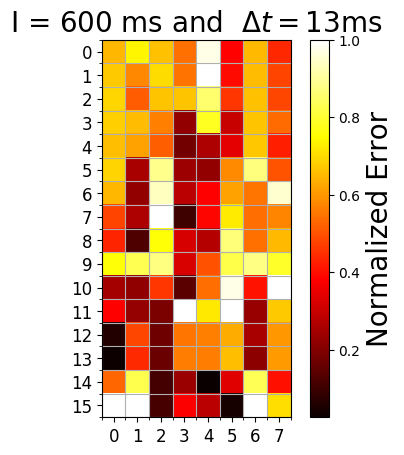

Final Result Size :  (17, 3, 27, 8)
Shape1 =  (17, 27, 8)


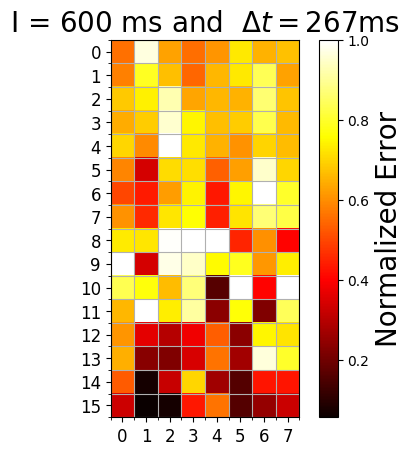

Final Result Size :  (17, 3, 27, 8)
Shape1 =  (17, 27, 8)


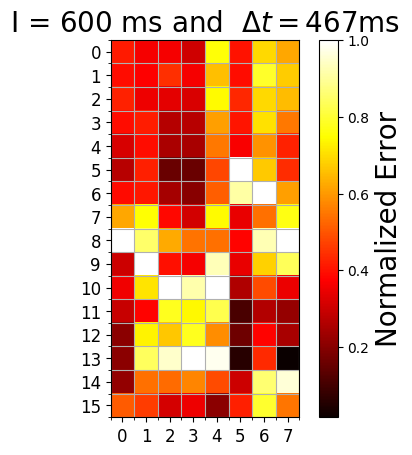

In [10]:
#timeStepList = [0, 5, 15, 25, 35]
#learningRate = [0.0002, 0.0002, 0.0002, 0.0001, 0.0001]
fileTimeList = ['2016-4-19-14-4', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']

subjectID = '2016-5-6-13-4'
subjectID = '\\' + subjectID + '\\'
currentPath = r"C:\Users\kb4000\Documents\Python\modellingbyrnn\Results\Figures\Ablation Study\PerSubjectModel"
tList = [13, 267, 467]
#integrationList = [2, 15, 45]
integrationList = [45]
j = 0
for deltaT in tList:
    for integrationLength in integrationList:
        #PredictionLength = 35
        #PredictionLength = 15
        blankPeriodDuration = 38
        featureDimension = 17

        mainMatrix = np.zeros((featureDimension, 3, 27, 8))# 27: Per Subject //// 243: All Subjects
        myMatrix = np.zeros((featureDimension, 3, 27, 8))# 27: Per Subject //// 243: All Subjects
        #myTest = np.zeros((3, 27, 8))# 27: Per Subject //// 243: All Subjects
        for i in range(featureDimension):
            #pickleFileName = r'.\Results\ModelOutput\17_Feat_8_Output_LSTM_25\modelOutput_2.pickle'
            ''' HACKED FOR VSS
            pickleFileName = r'.\Results\ModelOutput\newFeatureRemoval\testOutput_'+str(integrationLength)+'_'+str(i)+'.pickle'
            '''
            pickleFileName = r'.\Results\ModelOutput\PerSubjectModel'+subjectID+'testOutput_'+str(integrationLength)+'_'+str(i)+'.pickle'
            myTest = pd.read_pickle(pickleFileName)    
            #print('My Test: ', myTest.shape)
            #a = pd.read_pickle(pickleFileName)
            #myTest[0,:,:] = a[0,:,:]
            #myTest[1,:,:] = a[4,:,:]
            #myTest[2,:,:] = a[7,:,:]
            
            #myMatrix[i,0,:,:] = a[0,:,:]
            #myMatrix[i,1,:,:] = a[4,:,:]
            #myMatrix[i,2,:,:] = a[7,:,:]


            ''' HACKED FOR VSS
            pickleFileName = r'.\Results\ModelOutput\newFeatureRemoval\modelOutput_'+str(integrationLength)+'_'+str(i)+'.pickle'
            '''
            pickleFileName = r'.\Results\ModelOutput\PerSubjectModel'+subjectID+'modelOutput_'+str(integrationLength)+'_'+str(i)+'.pickle'

            myModel = pd.read_pickle(pickleFileName)    
            #print('myModel: ', myModel.shape)
            #mainMatrix[i,:,:,:] = np.divide(np.abs(myTest - myModel), np.abs(myTest))
            mainMatrix[i,:,:,:] = np.abs(myTest - myModel)
        print('Final Result Size : ', mainMatrix.shape)
        #plotResult(mainMatrix)
        #scale = np.std(myMatrix[:,0,:,:], axis = 1)
        #print(scale.shape)
        data = mainMatrix [:,j,:,:]
        print('Shape1 = ', data.shape)
        pd.to_pickle(data, currentPath+subjectID+'mean_'+str(integrationLength)+'_'+str(deltaT)+ '.pickle')
        data = np.mean(data, axis = 1)
        data = np.abs(np.divide(data, np.max(data, axis = 0)))

        fig = plt.figure(figsize=(5,5), dpi = 100)
        ax = fig.add_subplot(1,1,1)
        # major ticks every 20, minor ticks every 5                                      
        major_ticks = np.arange(0, 50, 1)                                              
        minor_ticks = np.arange(0-0.5, 50-0.5, 1)                                               

        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)                                           
        ax.set_yticks(major_ticks)                                                       
        ax.set_yticks(minor_ticks, minor=True)                                           

        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)

        # and a corresponding grid                                                       

        ax.grid(which='both')                                                            

        # or if you want differnet settings for the grids:                               
        ax.grid(which='minor', alpha=1.0)
        ax.grid(which='major', alpha=0.)
        plt.imshow(data[0:16,:], cmap="hot")
        #plt.xlabel('Output Feature', fontsize = 20)
        #plt.ylabel('Input Feature', fontsize = 20)
        cbar = plt.colorbar()
        cbar.set_label('Normalized Error', size=20)
        if integrationLength == 2:
            integrationLength = 2.025
        plt.title('I = '+str(int(integrationLength*(1000/75)))+' ms and  $\Delta t =$'+str(deltaT)+ 'ms', fontsize = 20 )
        #plt.savefig( currentPath+subjectID+'mean_'+str(integrationLength)+'_'+str(deltaT)+'.png', dpi=600)
        plt.show()
    j = j + 1

In [57]:
np.set_printoptions(suppress=True)
def plotData(data, integrationLength, deltaT):
    fig = plt.figure(figsize=(5,5), dpi = 100)
    ax = fig.add_subplot(1,1,1)
    # major ticks every 20, minor ticks every 5                                      
    major_ticks = np.arange(0, 50, 1)                                              
    minor_ticks = np.arange(0-0.5, 50-0.5, 1)                                               

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)                                           
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)                                           

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

    # and a corresponding grid                                                       

    ax.grid(which='both')                                                            

    # or if you want differnet settings for the grids:                               
    ax.grid(which='minor', alpha=1.0)
    ax.grid(which='major', alpha=0.)
    plt.imshow(data[0:16,:], cmap="hot")
    #plt.xlabel('Output Feature', fontsize = 20)
    #plt.ylabel('Input Feature', fontsize = 20)
    cbar = plt.colorbar()
    cbar.set_label('Normalized Error', size=20)
    if integrationLength == 2:
        integrationLength = 2.025
    plt.title('I = '+str(int(integrationLength*(1000/75)))+' ms and  $\Delta t =$'+str(deltaT)+ 'ms', fontsize = 18 )
    plt.savefig('myFigure.png', dpi=600)
    plt.show()

[  4.69353354   5.58692235  17.61298437  16.19037211   0.05505104
  45.1965655   10.0458327   39.0808721 ]

 [  1.94645888   2.04877518   6.43017816   4.94963846   0.04164252
  18.22961032   6.96323744  24.27374284]


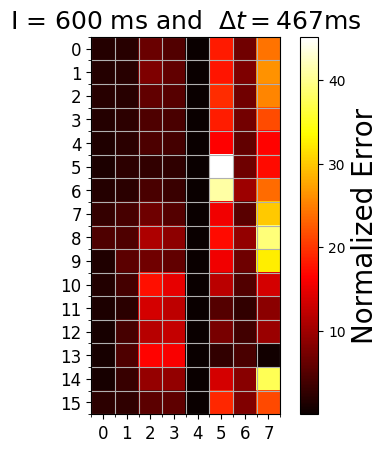


 [  1.94645888   2.04877518   6.43017816   4.94963846   0.04164252
  18.22961032   6.96323744  24.27374284]


In [63]:
subjectID = '2016-5-6-13-4'
subjectID = '\\' + subjectID + '\\'
integrationLength = 45
deltaT = 467
pickleFileName = r'.\Results\Figures\Ablation Study\PerSubjectModel'+subjectID+'mean_'+str(integrationLength)+'_'+str(deltaT)+'.pickle'
myTest = pd.read_pickle(pickleFileName)    
myTest.shape
myMean = np.mean(myTest, axis = 1)
myMax = np.max(myMean,axis = 0)
print(myMax)
print('\n', myMean[0,:])
myResult1 = np.divide(myMean, myMax)
myResult1 = myMean
plotData(myResult1, integrationLength, deltaT)
print('\n', myResult1[0,:])

[  5.37100987   8.0592247   17.26757523  40.15656017   0.095535
  19.05488593   8.32808399  13.60777016]

 [  1.98017609   2.37674613   9.7823838   23.42087584   0.08863796
  19.05488593   8.32808399  11.39835651]


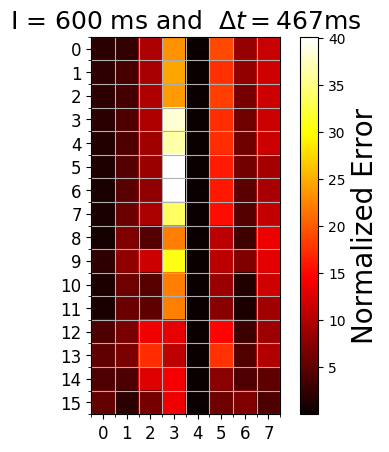


 [  1.98017609   2.37674613   9.7823838   23.42087584   0.08863796
  19.05488593   8.32808399  11.39835651]


In [64]:
subjectID = '2016-5-5-13-7'
subjectID = '\\' + subjectID + '\\'
integrationLength = 45
deltaT = 467
pickleFileName = r'.\Results\Figures\Ablation Study\PerSubjectModel'+subjectID+'mean_'+str(integrationLength)+'_'+str(deltaT)+'.pickle'
myTest = pd.read_pickle(pickleFileName)    
myTest.shape
myMean = np.mean(myTest, axis = 1)
myMax = np.max(myMean,axis = 0)
print(myMax)
print('\n', myMean[0,:])
myResult2 = np.divide(myMean, myMax)
myResult2 = myMean
plotData(myResult2, integrationLength, deltaT)
print('\n', myResult2[0,:])

In [65]:
a = myResult2-myResult1
b = a - a.min()
c = b*(2/b.max())
d = c - 1
print(d.min(), d.max())

-1.0 1.0


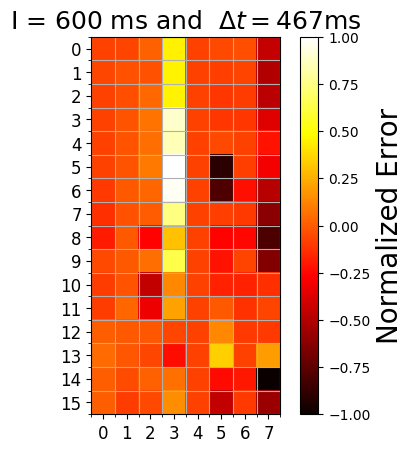

In [66]:
plotData((d), integrationLength, deltaT)

In [ ]:
print("Data = ")
i = 0
for item in data[0:16,4]:
    print("[%d]  %5.2f" %(i, item))
    i = i + 1

In [ ]:
mainMatrix = np.zeros((featureDimension, 3, 243, 8))

for i in range(featureDimension):
    pickleFileName = r'.\Results\ModelOutput\newFeatureRemoval\testOutput_15_35_'+str(i)+'.pickle'
    myTest = pd.read_pickle(pickleFileName)
    #print(myTest.shape)

    pickleFileName = r'.\Results\ModelOutput\newFeatureRemoval\modelOutput_15_35_'+str(i)+'.pickle'
    myModel = pd.read_pickle(pickleFileName)
    #print(myModel.shape)
    #mainMatrix[i,:,:,:] = np.divide(np.abs(myTest - myModel), np.abs(myTest))
    mainMatrix[i,:,:,:] = np.abs(myTest - myModel)
print('Final Result Size : ', mainMatrix.shape)
#plotResult(mainMatrix)

#print(mainMatrix)
data = mainMatrix [:,0,:,:]
#print('Shape1 = ', data.shape)

data = np.mean(data, axis = 1)
#data = np.divide(data, np.max(data, axis = 0))

fig = plt.figure(figsize=(5,5), dpi = 200)
ax = fig.add_subplot(1,1,1)
# major ticks every 20, minor ticks every 5                                      
major_ticks = np.arange(0, 50, 1)                                              
minor_ticks = np.arange(0-0.5, 50-0.5, 1)                                               

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)                                           
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)                                           

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=1.0)                                                
ax.grid(which='major', alpha=0.)
plt.imshow(data, cmap="hot")
plt.xlabel('Output Feature', fontsize = 20)
plt.ylabel('Input Feature', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Normalized STD Error', size=10)
plt.title('STD Error Covariance Matrix \nfor $\Delta t = 467 ms$', fontsize = 15 )
#plt.savefig('std_200_467.png', dpi=600)
plt.show()

In [ ]:
np.max(data, axis = 0)

In [ ]:
np.min(data, axis = 0)